In [2]:
%cd ..

/home/radaimi/Documents/influence-release-master


In [13]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import math
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import scipy
import scipy.linalg as slin
import scipy.sparse.linalg as sparselin
import scipy.sparse as sparse

sns.set(color_codes=True)
import sys
sys.path.append("/home/radaimi/Documents/influence-release-master")

from scripts.load_animals import load_animals
from influence.image_utils import plot_flat_colorimage, plot_flat_colorgrad

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

from sklearn.metrics.pairwise import rbf_kernel

from influence.inceptionModel import BinaryInceptionModel
from influence.smooth_hinge import SmoothHinge
from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
import influence.dataset as dataset
from influence.dataset import DataSet
from influence.dataset_poisoning import generate_inception_features

%matplotlib inline
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
num_classes = 2
num_train_ex_per_class = 900
num_test_ex_per_class = 300

model_name = 'dogfish_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
image_data_sets = load_animals(
    num_train_ex_per_class=num_train_ex_per_class, 
    num_test_ex_per_class=num_test_ex_per_class,
    classes=['dog', 'fish'])

Loading animals from disk...


In [5]:
X_train = image_data_sets.train.x
X_test = image_data_sets.test.x
Y_train = image_data_sets.train.labels * 2 - 1
Y_test = image_data_sets.test.labels * 2 - 1

In [6]:
def get_Y_pred_correct_inception(model):
    Y_test = model.data_sets.test.labels
    if np.min(Y_test) < -0.5:
        Y_test = (np.copy(Y_test) + 1) / 2        
    Y_pred = model.sess.run(model.preds, feed_dict=model.all_test_feed_dict)
    Y_pred_correct = np.zeros([len(Y_test)])
    for idx, label in enumerate(Y_test):
        Y_pred_correct[idx] = Y_pred[idx, int(label)]
    return Y_pred_correct


num_train = X_train.shape[0]
num_test = X_test.shape[0]

X_stacked = np.vstack((X_train, X_test))

gamma = 0.05
weight_decay = 0.0001

K = rbf_kernel(X_stacked, gamma = gamma / num_train)

L = slin.cholesky(K, lower=True)
L_train = L[:num_train, :num_train]
L_test = L[num_train:, :num_train]

### Compare top 5 influential examples from each network

test_idx = 462

## RBF

input_channels = 1
weight_decay = 0.001
batch_size = num_train
initial_learning_rate = 0.001 
keep_probs = None
max_lbfgs_iter = 1000
use_bias = False
decay_epochs = [1000, 10000]

tf.reset_default_graph()

X_train = image_data_sets.train.x
Y_train = image_data_sets.train.labels * 2 - 1
train = DataSet(L_train, Y_train)
test = DataSet(L_test, Y_test)

data_sets = base.Datasets(train=train, validation=None, test=test)
input_dim = data_sets.train.x.shape[1]

# Train with hinge
rbf_model = SmoothHinge(
    temp=0,
    use_bias=use_bias,
    input_dim=input_dim,
    weight_decay=weight_decay,
    num_classes=num_classes,
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='dogfish_rbf_hinge_t-0')
    
rbf_model.train()
hinge_W = rbf_model.sess.run(rbf_model.params)[0]

# Then load weights into smoothed version
tf.reset_default_graph()
rbf_model = SmoothHinge(
    temp=0.001,
    use_bias=use_bias,
    input_dim=input_dim,
    weight_decay=weight_decay,
    num_classes=num_classes,
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='dogfish_rbf_hinge_t-0.001')

params_feed_dict = {}
params_feed_dict[rbf_model.W_placeholder] = hinge_W
rbf_model.sess.run(rbf_model.set_params_op, feed_dict=params_feed_dict)

rbf_predicted_loss_diffs = rbf_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(rbf_model.data_sets.train.labels)),
    force_refresh=True)


## Inception

dataset_name = 'dogfish_900_300'

# Generate inception features
img_side = 299
num_channels = 3
num_train_ex_per_class = 900
num_test_ex_per_class = 300
batch_size = 100


tf.reset_default_graph()
full_model_name = '%s_inception' % dataset_name
full_model = BinaryInceptionModel(
    img_side=img_side,
    num_channels=num_channels,
    weight_decay=weight_decay,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=image_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=True,
    train_dir='output',
    log_dir='log',
    model_name=full_model_name)

train_inception_features_val = generate_inception_features(
    full_model, 
    image_data_sets.train.x, 
    image_data_sets.train.labels, 
    batch_size=batch_size)        
test_inception_features_val = generate_inception_features(
    full_model, 
    image_data_sets.test.x, 
    image_data_sets.test.labels, 
    batch_size=batch_size)  

train = DataSet(
    train_inception_features_val,
    image_data_sets.train.labels)
test = DataSet(
    test_inception_features_val,
    image_data_sets.test.labels)

validation = None

data_sets = base.Datasets(train=train, validation=validation, test=test)

input_dim = 2048
weight_decay = 0.001
batch_size = 1000
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000
num_classes = 2

tf.reset_default_graph()

inception_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='%s_inception_onlytop' % dataset_name)

inception_model.train()

inception_predicted_loss_diffs = inception_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(inception_model.data_sets.train.labels)),
    force_refresh=True)

x_test = X_test[test_idx, :]
y_test = Y_test[test_idx]


distances = dataset.find_distances(x_test, X_train)
flipped_idx = Y_train != y_test
rbf_margins_test = rbf_model.sess.run(rbf_model.margin, feed_dict=rbf_model.all_test_feed_dict)
rbf_margins_train = rbf_model.sess.run(rbf_model.margin, feed_dict=rbf_model.all_train_feed_dict)
inception_Y_pred_correct = get_Y_pred_correct_inception(inception_model)


np.savez(
    'output/rbf_results', 
    test_idx=test_idx,
    distances=distances,
    flipped_idx=flipped_idx,
    rbf_margins_test=rbf_margins_test,
    rbf_margins_train=rbf_margins_train,
    inception_Y_pred_correct=inception_Y_pred_correct,
    rbf_predicted_loss_diffs=rbf_predicted_loss_diffs,
    inception_predicted_loss_diffs=inception_predicted_loss_diffs
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Total number of parameters: 1800
Using normal model
SVM training took 25 iter.
After SVM training: 
Train loss (w reg) on all data: 0.61188793
Train loss (w/o reg) on all data: 0.37685642
Test loss (w/o reg) on all data: 0.74733716
Train acc on all data:  0.92
Test acc on all data:   0.7083333333333334
Norm of the mean of gradients: 0.008666405
Norm of the params: 21.680937
Total number of parameters: 1800
Norm of test gradient: 0.57139254
Function value: -30.767854690551758
Split function value: 30.76764488220215, -61.5355
Predicted loss diff on train_idx 5: 0.006653725306193034
Function value: -31.011821746826172
Split function value: 30.52203369140625, -61.533855
Predicted loss diff on train_idx 5: 0.006637823846605089
Function value: -31.039052963256836
Split function value: 30.498273849487305, -61.537327
Predicted loss diff on train_idx 5: 0.0066229364607069225
F

/home/radaimi/Documents/influence-release-master/influence_env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


(1800, 268203)
(600, 268203)
Total number of parameters: 2048
Using normal model
LBFGS training took [42] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.01212904
Train loss (w/o reg) on all data: 0.003976129
Test loss (w/o reg) on all data: 0.048454043
Train acc on all data:  1.0
Test acc on all data:   0.985
Norm of the mean of gradients: 3.6104618e-07
Norm of the params: 4.0380473
Norm of test gradient: 0.045669425
Function value: -0.2157452553510666
Split function value: 0.2157324105501175, -0.43147767
Predicted loss diff on train_idx 5: -1.5837881558885178e-06
Function value: -0.22342032194137573
Split function value: 0.20807045698165894, -0.43149078
Predicted loss diff on train_idx 5: -1.5679485578503873e-06
Function value: -0.22614717483520508
Split function value: 0.22233307361602783, -0.44848025
Predicted loss diff on train_idx 5: -1.4837599721633725e-06
Function value: -0.22623561322689056
Split function value: 0.22540967166423798, -0.45164528
Predicted lo

In [7]:
f = np.load('output/rbf_results.npz')
    
test_idx = f['test_idx']
distances = f['distances']
flipped_idx = f['flipped_idx']
rbf_margins_test = f['rbf_margins_test']
rbf_margins_train = f['rbf_margins_train']
inception_Y_pred_correct = f['inception_Y_pred_correct']
rbf_predicted_loss_diffs = f['rbf_predicted_loss_diffs']
inception_predicted_loss_diffs = f['inception_predicted_loss_diffs']

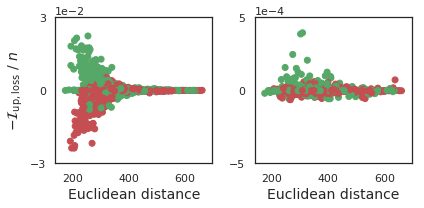

In [9]:
sns.set_style('white')
fontsize=14

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6, 3))

num_train = len(flipped_idx)
color_vec = np.array(['g'] * num_train)
color_vec[flipped_idx] = 'r'
color_vec = list(color_vec)

axs[0].scatter(distances, rbf_predicted_loss_diffs, color=color_vec)
axs[0].set_ylim(-0.03, 0.03)
axs[0].set_yticks((-0.03, 0, 0.03))
axs[0].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[0].set_xlabel('Euclidean distance', fontsize=fontsize)
axs[0].set_ylabel('$-\mathcal{I}_\mathrm{up, loss} \ /\ n$', fontsize=fontsize)

axs[1].scatter(distances, inception_predicted_loss_diffs, color=color_vec)
axs[1].set_ylim(-0.0005, 0.0005)
axs[1].set_yticks((-0.0005, 0, 0.0005))
axs[1].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[1].set_xlabel('Euclidean distance', fontsize=fontsize)

plt.tight_layout()
plt.savefig('fig-rbf-dist.png', dpi=600, bbox_inches='tight')

Test image:
1.0 0.9900307 0.9965987801551819


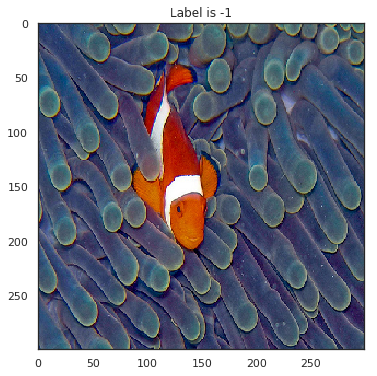

Top from RBF:
1103 1.0 194.05157 0.28052014 0.01816176520453559
1700 1.0 231.3802 0.20581147 0.018329910702175566
286 1.0 206.63591 0.6800409 0.020471102396647137
765 1.0 214.33142 -0.3200709 0.021519989437527125
925 1.0 254.57011 0.44896263 0.02236267513699002


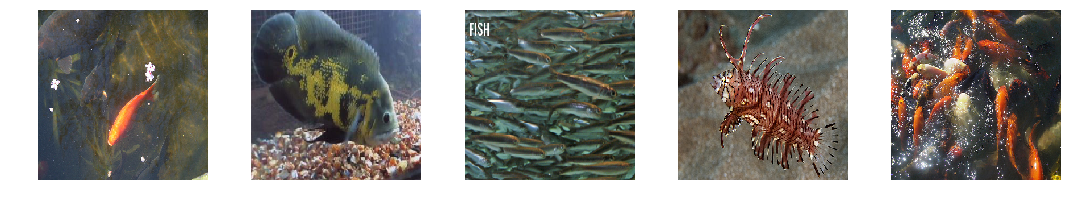

Top from Inception:
1250 1.0 246.74 0.00015672256549199422
550 1.0 325.7334 0.00020648300647735596
1723 1.0 273.8491 0.00024592025412453544
203 1.0 301.6817 0.0003860586550500658
1380 1.0 308.69556 0.0003946133123503791


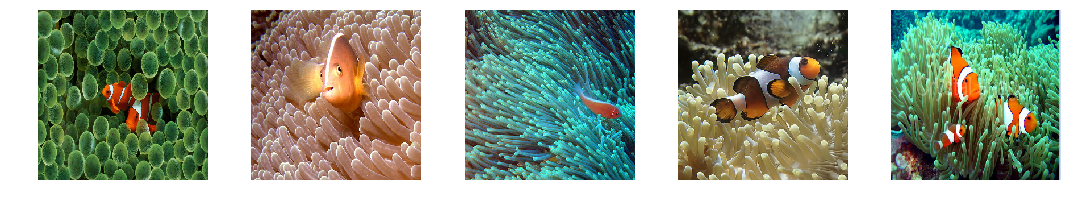

Dogs from Inception:
19 526 -1.0 637.901 7.16553462876214e-05
23 664 -1.0 350.88843 5.9897775451342264e-05
25 607 -1.0 313.91873 5.849132521284951e-05
26 786 -1.0 346.762 5.5775224334663815e-05
27 1623 -1.0 398.6983 5.476173841291004e-05


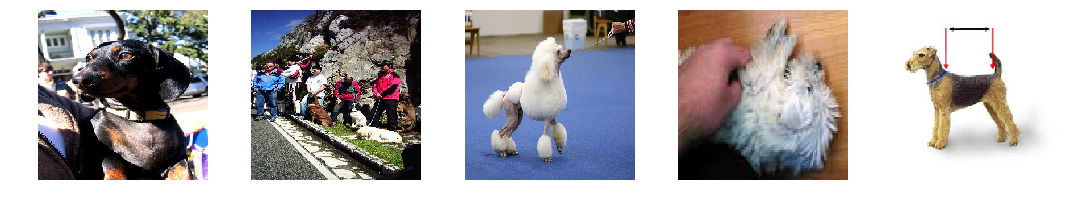

In [18]:
print('Test image:')
print(Y_test[test_idx], rbf_margins_test[test_idx], inception_Y_pred_correct[test_idx])
plot_flat_colorimage((X_test[test_idx, :] + 1) / 2, 0, side=299)
    
print('Top from RBF:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(rbf_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], rbf_margins_train[train_idx], rbf_predicted_loss_diffs[train_idx])
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
plt.savefig('fig-rbf-fishes.png', dpi=600, bbox_inches='tight')
plt.show()

print('Top from Inception:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(inception_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], inception_predicted_loss_diffs[train_idx])    
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
plt.savefig('fig-inception-fishes.png', dpi=600, bbox_inches='tight')
plt.show()

print('Dogs from Inception:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
counter = 4
for i, train_idx in enumerate(np.argsort(inception_predicted_loss_diffs)[:-50:-1]):
    if Y_train[train_idx] == -1.0:
        print(i, train_idx, Y_train[train_idx], distances[train_idx], inception_predicted_loss_diffs[train_idx])    
        x_train = X_train[train_idx, :]
        axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
        axs[counter].axis('off')
        counter -= 1
    if counter == -1:
        break
plt.tight_layout()
plt.savefig('fig-inception-dogs.png', dpi=600, bbox_inches='tight')
plt.show()

Norm of test gradient: 0.45071656
Function value: -44.80119705200195
Split function value: 44.80141830444336, -89.602615
Predicted loss diff on train_idx 5: 0.008441294034322103
Function value: -44.91183090209961
Split function value: 44.69021987915039, -89.60205
Predicted loss diff on train_idx 5: 0.008427539931403267
Function value: -44.94613265991211
Split function value: 44.71842575073242, -89.66456
Predicted loss diff on train_idx 5: 0.008404622607760958
Function value: -44.95133972167969
Split function value: 44.736473083496094, -89.68781
Predicted loss diff on train_idx 5: 0.008413939476013184
Function value: -44.95787811279297
Split function value: 44.84852600097656, -89.806404
Predicted loss diff on train_idx 5: 0.008432507514953613
Function value: -44.95854568481445
Split function value: 44.9295539855957, -89.8881
Predicted loss diff on train_idx 5: 0.00844174649980333
Function value: -44.95856475830078
Split function value: 44.95348358154297, -89.91205
Predicted loss diff on

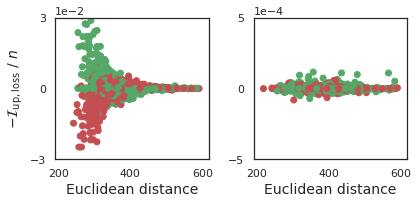

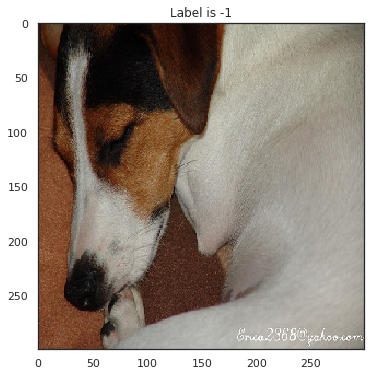

Top from RBF:
842 -1.0 281.60156 0.41960788 0.03202946980794271
1781 -1.0 257.7711 0.9116485 0.03566861894395616
477 -1.0 257.3073 0.96450627 0.037523167928059896
1387 -1.0 261.72287 0.77966654 0.041576109992133244
329 -1.0 251.58789 0.92019594 0.055458997090657554


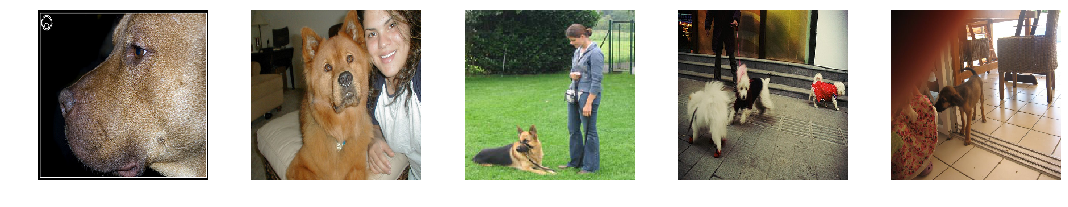

Top from Inception:
1282 -1.0 319.3409 9.423674808608162e-05
1623 -1.0 479.39188 9.883400466707018e-05
526 -1.0 565.8826 0.00010941745506392585
1405 -1.0 435.66006 0.00011030803951952192
361 -1.0 357.44797 0.00011593470142947304


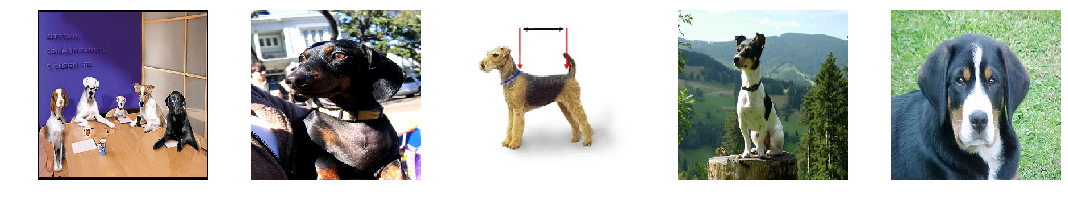

Fish:
9 1390 1.0 418.632 5.8722847865687474e-05
10 887 1.0 414.7452 5.62681837214364e-05
18 1058 1.0 400.03308 4.132144980960422e-05
20 1475 1.0 289.8099 3.95712008078893e-05
21 403 1.0 364.50018 3.88783175084326e-05


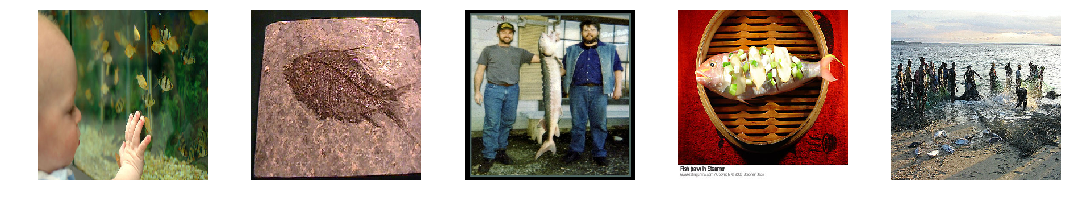

In [22]:
# Dog test image
test_idx = 500

rbf_predicted_loss_diffs = rbf_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(rbf_model.data_sets.train.labels)),
    force_refresh=True)

inception_predicted_loss_diffs = inception_model.get_influence_on_test_loss(
    [test_idx], 
    np.arange(len(inception_model.data_sets.train.labels)),
    force_refresh=True)

x_test = X_test[test_idx, :]
y_test = Y_test[test_idx]


distances = dataset.find_distances(x_test, X_train)
flipped_idx = Y_train != y_test
rbf_margins_test = rbf_model.sess.run(rbf_model.margin, feed_dict=rbf_model.all_test_feed_dict)
rbf_margins_train = rbf_model.sess.run(rbf_model.margin, feed_dict=rbf_model.all_train_feed_dict)
inception_Y_pred_correct = get_Y_pred_correct_inception(inception_model)


np.savez(
    'output/inception_results_v2', 
    test_idx=test_idx,
    distances=distances,
    flipped_idx=flipped_idx,
    rbf_margins_test=rbf_margins_test,
    rbf_margins_train=rbf_margins_train,
    inception_Y_pred_correct=inception_Y_pred_correct,
    rbf_predicted_loss_diffs=rbf_predicted_loss_diffs,
    inception_predicted_loss_diffs=inception_predicted_loss_diffs
)

f = np.load('output/inception_results_v2.npz')
    
test_idx = f['test_idx']
distances = f['distances']
flipped_idx = f['flipped_idx']
rbf_margins_test = f['rbf_margins_test']
rbf_margins_train = f['rbf_margins_train']
inception_Y_pred_correct = f['inception_Y_pred_correct']
rbf_predicted_loss_diffs = f['rbf_predicted_loss_diffs']
inception_predicted_loss_diffs = f['inception_predicted_loss_diffs']

sns.set_style('white')
fontsize=14

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6, 3))

num_train = len(flipped_idx)
color_vec = np.array(['g'] * num_train)
color_vec[flipped_idx] = 'r'
color_vec = list(color_vec)

axs[0].scatter(distances, rbf_predicted_loss_diffs, color=color_vec)
axs[0].set_ylim(-0.03, 0.03)
axs[0].set_yticks((-0.03, 0, 0.03))
axs[0].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[0].set_xlabel('Euclidean distance', fontsize=fontsize)
axs[0].set_ylabel('$-\mathcal{I}_\mathrm{up, loss} \ /\ n$', fontsize=fontsize)

axs[1].scatter(distances, inception_predicted_loss_diffs, color=color_vec)
axs[1].set_ylim(-0.0005, 0.0005)
axs[1].set_yticks((-0.0005, 0, 0.0005))
axs[1].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[1].set_xlabel('Euclidean distance', fontsize=fontsize)

plt.tight_layout()
plt.savefig('fig-rbf-inception-dist-dogs.png', dpi=600, bbox_inches='tight')

print('Test image:')
print(Y_test[test_idx], rbf_margins_test[test_idx], inception_Y_pred_correct[test_idx])
plot_flat_colorimage((X_test[test_idx, :] + 1) / 2, 0, side=299)
    
print('Top from RBF:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(rbf_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], rbf_margins_train[train_idx], rbf_predicted_loss_diffs[train_idx])
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
plt.savefig('fig-rbf-dogs.png', dpi=600, bbox_inches='tight')
plt.show()

print('Top from Inception:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(inception_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], inception_predicted_loss_diffs[train_idx])    
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
plt.savefig('fig-inception-dogs-test-class.png', dpi=600, bbox_inches='tight')
plt.show()

print('Fish:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
counter = 4
for i, train_idx in enumerate(np.argsort(inception_predicted_loss_diffs)[:-50:-1]):
    if Y_train[train_idx] == 1.0:
        print(i, train_idx, Y_train[train_idx], distances[train_idx], inception_predicted_loss_diffs[train_idx])    
        x_train = X_train[train_idx, :]
        axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
        axs[counter].axis('off')
        counter -= 1
    if counter == -1:
        break
plt.tight_layout()
plt.savefig('fig-inception-fishes-opp-class.png', dpi=600, bbox_inches='tight')
plt.show()